In [411]:
import numpy as np
import pandas as pd
from scipy import stats
from math import exp, log
from collections import deque
from sklearn.linear_model import LogisticRegression

from toy_data import generate_training_data, plot_data

%matplotlib inline

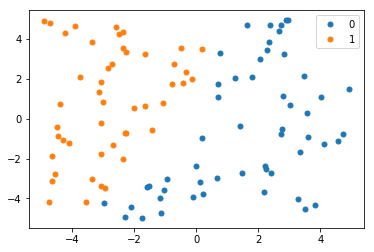

In [450]:
toy_data = generate_training_data(100, -0.5, 1)
plot_data(toy_data)

In [451]:
features = np.array(toy_data.drop('label', axis=1))
labels = np.array(toy_data['label'])

In [484]:
def gini(x):
    n = len(x)
    if n==0:
        return 0
    ones = np.sum(x)
    zeros = n - ones
    p0 = 1.0*zeros/n
    p1 = 1.0*ones/n
    return p0*(1-p0) + p1*(1-p1)

def info_gain(x, y, split_val):
    n = len(x)
    splitL = y[x<split_val]
    splitR = y[x>=split_val]
    return gini(y) - ((1.0*len(splitL)/n)*gini(splitL) + (1.0*len(splitR)/n)*gini(splitR))

def find_best_split_value(x, y, n_splits=10):
    splits = np.quantile(x, q=np.arange(0, 1, 1.0/n_splits))
    max_gain = -1
    for split in splits:
        gain = info_gain(x, y, split)
        if gain > max_gain:
            best_split = split
            max_gain = gain
    return (best_split, max_gain)

def find_best_split(features, labels):
    n_cols = features.shape[1]
    max_gain = -1
    for i in range(n_cols):
        features_i = features[:, i]
        split, gain = find_best_split_value(features_i, labels, n_splits=10)
        if gain > max_gain:
            max_gain = gain
            best_split_value = split
            best_feature_index = i
    return (best_feature_index, best_split_value)


class node(object):
    def __init__(self, features, labels, depth):
        self.features = features
        self.labels = labels
        self.gini = gini(labels)
        self.depth = depth
        self.split_feature_index = None
        self.split_value = None
        self.left_child = None
        self.right_child = None
        self.major_class = None
    
    def set_split(self, split_feature_index, split_value):
        self.split_feature_index = split_feature_index
        self.split_value = split_value
        self.left_child = self.get_child('left', split_feature_index, split_value)
        self.right_child = self.get_child('right', split_feature_index, split_value)
    
    def clear_data(self):
        self.features = None
        self.labels = None
    
    def get_child(self, side, index, split_value):
        if side == 'left':
            condition = self.features[:, index]<split_value
        if side == 'right':
            condition = self.features[:, index]>=split_value
        child_labels = self.labels[condition]
        child_features = self.features[condition, :]
        return node(child_features, child_labels, self.depth+1)
    
    def trickle(self, features):
        """used by predict method to predict label from feature vector"""
        if self.split_feature_index is None:
            return None
        if features[self.split_feature_index] < self.split_value:
            return self.left_child
        else:
            return self.right_child
    
    def __str__(self):
        return "split_feature_index: %s, split_value: %s" % (self.split_feature_index, self.split_value)
        

In [485]:
class DecisionTree(object):
    def __init__(self, max_depth):
        self.max_depth = max_depth

    def fit(self, features, labels):
        features = np.array(features)
        labels = np.array(labels)
        leaves = deque([node(features, labels, 0)])
        while len(leaves) > 0:
            leaf = leaves.popleft()
            if leaf.gini > 0 and leaf.depth < self.max_depth:
                best_feature_index, best_split_value = find_best_split(leaf.features, leaf.labels)
                leaf.set_split(best_feature_index, best_split_value)
                leaf.clear_data()
                leaves.append(leaf.left_child)
                leaves.append(leaf.right_child)
            else:
                leaf.major_class = stats.mode(leaf.labels).mode[0]
            if leaf.depth == 0:
                self.root = leaf
    
    def predict(self, features):
        features = np.array(features)
        leaf = self.root
        while leaf.major_class is None:
            leaf = leaf.trickle(features)
        return leaf.major_class

In [492]:
dt = DecisionTree(3)
dt.fit(features, labels)

In [493]:
import random
i = random.randint(0, len(labels)-1)
print(features[i], labels[i])
dt.predict(features[i])

(array([-2.36923084,  3.53572072]), 1)


1

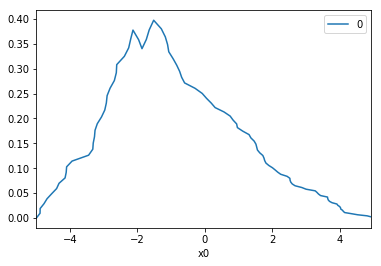

In [147]:
y = toy_data['label']
x = toy_data['x0']
splits = x.quantile(np.arange(0, 1, 0.01))
pd.DataFrame([info_gain(x, y, split) for split in splits], index=splits).plot()

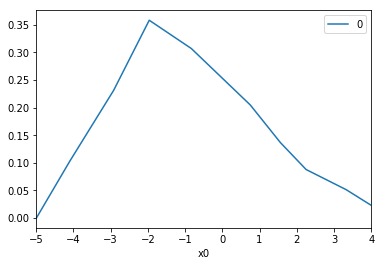

In [142]:
splits = x.quantile(np.arange(0, 1, 0.1))
pd.DataFrame([info_gain(x, y, split) for split in splits], index=splits).plot()